#Task 1: Multi-Label Classification Using Machine Learning

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, accuracy_score, hamming_loss, roc_auc_score, roc_curve

data = fetch_openml('mnist_784', version=1)

## Convert your labels y into a multi-label format, by creating two columns:

    - Odd or Not: This column indicates whether the label is odd (True) or not (False).
    - Greater Than 5: This column indicates whether the label is greater than 5 (True) or not (False).

In [6]:
data = fetch_openml('mnist_784', version=1)
X = np.array(data.data)
y = np.array(data.target, dtype=int)

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Unique labels: {np.unique(y)}")

df = pd.DataFrame(X, columns=[f'pixel{i+1}' for i in range(X.shape[1])])
df["target"]=y
df.head()

Features shape: (70000, 784)
Labels shape: (70000,)
Unique labels: [0 1 2 3 4 5 6 7 8 9]


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


## Odd Convert

In [8]:
isodd = (y % 2 != 0).astype(int) #binary classification of odd numbers. 1 as odd, 0 as even.
print(f"Odd or Not: {isodd[:10]}")
print(f"Original labels: {y[:10]}")

Odd or Not: [1 0 0 1 1 0 1 1 1 0]
Original labels: [5 0 4 1 9 2 1 3 1 4]


## Greater than 5

In [9]:
greater_than_5 = (y > 5).astype(int)
print(f"Greater than 5: {greater_than_5[:10]}")
print(f"Original labels: {y[:10]}")

Greater than 5: [0 0 0 0 1 0 0 0 0 0]
Original labels: [5 0 4 1 9 2 1 3 1 4]


You may use np.stack() to combine your columns

In [14]:
y_multi = np.stack([isodd, greater_than_5], axis=1) # new array with only 2 columns.
print(f"Multi-label shape: {y_multi.shape}")
print(f"First 10 multi-labels (Odd, >5):\n{y_multi[:10]}")
print(f"Corresponding original digits: {y[:10]}")


Multi-label shape: (70000, 2)
First 10 multi-labels (Odd, >5):
[[1 0]
 [0 0]
 [0 0]
 [1 0]
 [1 1]
 [0 0]
 [1 0]
 [1 0]
 [1 0]
 [0 0]]
Corresponding original digits: [5 0 4 1 9 2 1 3 1 4]


## Build a model that predict two labels

the model will take X (the pixel data) as input and learn to predict both isodd and greater_than_5 simultaneously, using y_multi as the ground truth.

We don't need to aggregate y_multi back to y because y_multi is the multi-label representation we want to predict. If we were to pass y to the model, it would be a multi-class classification problem (predicting a single digit from 0-9), not a multi-label one.

Intuition: Why RandomForest?



1.   **Handles High-Dimensional Data**: The MNIST dataset involves 784 pixel features (X.shape[1]), which is a relatively high-dimensional input. Random Forests are effective in handling such datasets without extensive feature engineering or scaling.
2.  **Feature Importance:** Random Forests can implicitly tell you which features (pixels) are most important for making predictions. While not explicitly used in this evaluation, it's a valuable property for understanding the model.






In [18]:
# Normalize pixel values to [0, 1]
X_normalized = X / 255.0

X_train, X_test, y_multi_train, y_multi_test = train_test_split(X_normalized, y_multi, test_size=0.2, random_state=42)

# Initialize an estimator
base_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Wrap the base estimator in MultiOutputClassifier
multi_label_classifier = MultiOutputClassifier(base_classifier, n_jobs=-1) #to control parallel processing. When you set n_jobs=-1, it means that the estimator should use all available CPU cores for computation.

# Train the classifier
multi_label_classifier.fit(X_train, y_multi_train)

print("Multi-label classifier trained successfully!")

Multi-label classifier trained successfully!


**How MultiOutputClassifier works theoretically**

***One Classifier Per Target***: Instead of trying to predict all labels at once with a single complex model, MultiOutputClassifier takes a simpler classifier (like our RandomForestClassifier) and trains a separate instance of that base classifier for each target variable. So it will train one RandomForestClassifier to predict isodd and another RandomForestClassifier to predict greater_than_5.

***Independent Predictions:*** Each of these individual base classifiers learns to predict its specific target label independently of the others. When you make a prediction with the MultiOutputClassifier, it simply passes the input features (X_test) to each of these trained base classifiers, and then combines their individual predictions into a single multi-label output.

## Use the right metrics to evaluate your model

In [20]:
# Predictions
y_pred = multi_label_classifier.predict(X_test)

# Hamming Loss (lower is better)
print(f"Hamming Loss: {hamming_loss(y_multi_test, y_pred):.4f}")

# Exact Match Ratio (both labels must be correct)
exact_match = np.all(y_pred == y_multi_test, axis=1).mean()
print(f"Exact Match Ratio: {exact_match:.4f}")

# Per-label accuracy
print(f"\nAccuracy - Odd or Not: {accuracy_score(y_multi_test[:, 0], y_pred[:, 0]):.4f}")
print(f"Accuracy - Greater Than 5: {accuracy_score(y_multi_test[:, 1], y_pred[:, 1]):.4f}")

# Classification report for each label
print("\n--- Classification Report: Odd or Not ---")
print(classification_report(y_multi_test[:, 0], y_pred[:, 0], target_names=['Even', 'Odd']))

print("--- Classification Report: Greater Than 5 ---")
print(classification_report(y_multi_test[:, 1], y_pred[:, 1], target_names=['<= 5', '> 5']))

Hamming Loss: 0.0248
Exact Match Ratio: 0.9574

Accuracy - Odd or Not: 0.9781
Accuracy - Greater Than 5: 0.9722

--- Classification Report: Odd or Not ---
              precision    recall  f1-score   support

        Even       0.97      0.98      0.98      6771
         Odd       0.98      0.98      0.98      7229

    accuracy                           0.98     14000
   macro avg       0.98      0.98      0.98     14000
weighted avg       0.98      0.98      0.98     14000

--- Classification Report: Greater Than 5 ---
              precision    recall  f1-score   support

        <= 5       0.97      0.98      0.98      8324
         > 5       0.98      0.96      0.97      5676

    accuracy                           0.97     14000
   macro avg       0.97      0.97      0.97     14000
weighted avg       0.97      0.97      0.97     14000



In [21]:
import matplotlib.pyplot as plt

# Get predicted probabilities for each label
y_proba = multi_label_classifier.predict_proba(X_test)

# Calculate ROC AUC for each label
roc_auc_odd = roc_auc_score(y_multi_test[:, 0], y_proba[0][:, 1])
roc_auc_gt5 = roc_auc_score(y_multi_test[:, 1], y_proba[1][:, 1])

print(f"ROC AUC - Odd or Not: {roc_auc_odd:.4f}")
print(f"ROC AUC - Greater Than 5: {roc_auc_gt5:.4f}")

ROC AUC - Odd or Not: 0.9974
ROC AUC - Greater Than 5: 0.9961


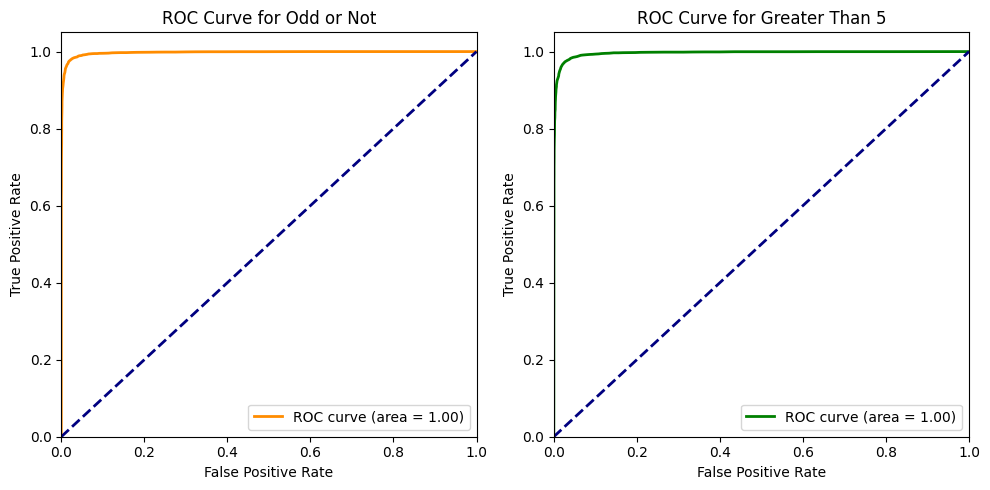

In [22]:
# Plot ROC curves
plt.figure(figsize=(10, 5))

# ROC for 'Odd or Not'
fpr_odd, tpr_odd, _ = roc_curve(y_multi_test[:, 0], y_proba[0][:, 1])
plt.subplot(1, 2, 1)
plt.plot(fpr_odd, tpr_odd, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_odd:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Odd or Not')
plt.legend(loc='lower right')

# ROC for 'Greater Than 5'
fpr_gt5, tpr_gt5, _ = roc_curve(y_multi_test[:, 1], y_proba[1][:, 1])
plt.subplot(1, 2, 2)
plt.plot(fpr_gt5, tpr_gt5, color='green', lw=2, label=f'ROC curve (area = {roc_auc_gt5:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Greater Than 5')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

Interpretation:

High AUC Scores: Both ROC AUC scores are very close to 1.0 (the maximum possible value). An AUC of 1.0 indicates a perfect classifier that can distinguish between positive and negative classes with 100% accuracy. Our scores of 0.9974 and 0.9961 are exceptionally high, suggesting that the multi-label classifier is performing extremely well in distinguishing between odd/even digits and digits greater/less than 5.

ROC Curves: The ROC (Receiver Operating Characteristic) curves visually represent the trade-off between the True Positive Rate (TPR) and the False Positive Rate (FPR) at various threshold settings. The closer the curve is to the top-left corner of the plot, the better the model's performance. Since both our curves are very close to the top-left corner and have large areas under them (as indicated by the high AUC scores), this confirms the excellent performance of your multi-label classifier for both tasks.

These metrics collectively demonstrate that your MultiOutputClassifier, using RandomForestClassifier as its base estimator, has learned to predict both labels with high accuracy and strong discriminatory power.